## Importing libraries

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
from wordcloud import WordCloud 


## Load data

In [89]:
df = pd.read_csv('data/data - data.csv')
df.head()

,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!! :)),POS,5,NaN
1,Tuyệt vời ! okey,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN


In [90]:
#make class column = y_train
#by rename unnamed: 3 to class
df = df.rename({'Unnamed: 3': 'class'}, axis=1)
df.head()

,comment,label,rate,class
0,Áo bao đẹp ạ!! :)),POS,5,NaN
1,Tuyệt vời ! okey,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN


## Select number of class 
Custom yourself

#### 2 class: -1 or 1
    Class 1 = Rate > 3
    Class 2 = Rate < 3
#### 5 class: 1 2 3 4 5
    Class 1 = Rate 1
    Class 2 = Rate 2 
    Class 3 = Rate 3
    Class 4 = Rate 4
    Class 5 = Rate 5

In [91]:
# select number of class (5 or 2)
sel_class = 5
index_list = []

if sel_class == 2:
    #rate = 3 will be dropped because they are neutral
    df = df[df['rate'] != 3]
    #assign class with rate > 3 as positive sentiment +1
    #rate < 3 as negativte sentiment
    df['class'] = df['rate'].apply(lambda rating: 2 if rating > 3 else 1)

elif sel_class == 5:
    #class = rate
    df['class'] = df['rate']

df.head()

,comment,label,rate,class
0,Áo bao đẹp ạ!! :)),POS,5,5
1,Tuyệt vời ! okey,POS,5,5
2,2day ao khong giong trong.,NEG,1,1
3,"Mùi thơm,bôi lên da mềm da.",POS,5,5
4,"Vải đẹp, dày dặn.",POS,5,5


In [93]:
#get the shortest class value and length
shortest_class = df['rate'].value_counts().idxmin()
df_length = len(df[df['rate']==shortest_class])

#init df for equal length
df_equal = df[df['rate'] == shortest_class].sample(n=df_length)

sel_range = sel_class + 1
for i in [x for x in range(1,sel_range) if x != shortest_class]:
    condition_str = 'rate == {}'.format(i)
    df_equal = df_equal.append(df.query(condition_str).sample(n=df_length))
    
df_equal = df_equal.sample(frac=1)
print(df_equal)

                                                 comment label  rate  class
27725  Hàng ok nhưng đóng gói hàng chưa kỹ, bị bể 1 b...   NEG     2      2
15119                   M báo lấy xxxl gửi cho m có xxl.   NEG     2      2
2651                     Tạm dc, chưa biết có bền không.   NEU     3      3
5187   E đề nghị shop kiểm tra sản phẩm chắc chắn trư...   NEG     2      2
18978  Chất lượng sản phẩm tuyệt vời Đóng gói sản phẩ...   POS     5      5
...                                                  ...   ...   ...    ...
591    Giao hàng nhanh, quần đẹp đáng so với tiền bỏ ...   POS     5      5
3839                      Sản phẩm không giống hình mẫu.   NEU     3      3
2058   Chất lượng sản phẩm tuyệt vời Đóng gói sản phẩ...   POS     5      5
14701                                To hơn tưởng tượng.   NEG     2      2
12772                  Lần đầu và cũng là lần cuối cùng.   NEG     1      1

[15700 rows x 4 columns]


In [94]:
#show rating class chart
fig = px.histogram(df, x = "class")
fig.update_traces(marker_color="turquoise",
                  marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Original Rating class')
fig.show()

fig = px.histogram(df_equal, x = "class")
fig.update_traces(marker_color="turquoise",
                  marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Equal Rating class')
fig.show()

## Data cleaning

In [95]:
#load stopwords from file

def load_stopwords(inpath = "data/vietnamese-stopwords.txt"):

    stopwords = set()
    with open(inpath, encoding = 'utf-8') as f:
        lines = f.readlines()
        for l in lines:
            l = l.strip().lower()
            if len(l) > 0:
                stopwords.add(l)
    return stopwords 

stopwords = load_stopwords()
#update more understate words to stopwords
stopwords.update(['br', 'href', u'rằng',u'thì',u'là',u'mà'])

In [96]:
#remove punctuation in comments
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?",".",";",":","!",'"',"[","]","(",")","<",">"))
    return final

In [97]:
#lower all character
def lower_character(text):
    final = text.lower()
    return final

In [98]:
#replace emoji
def replace_emoji(text):
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": "nagative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "nagative", "😱": "nagative", "😸": "positive",
        "😾": "nagative", "🚫": "nagative",  "🤬": "nagative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' nagative ', '😣': ' nagative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', '😢': ' nagative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' nagative ', '😊': ' positive ',
        '😁': ' positive ', '💖': ' positive ', '😟': ' nagative ', '😭': ' nagative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' nagative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' nagative ', '😀': ' positive ', '😡': ' nagative ', '😠': ' nagative ',
        '😒': ' nagative ', '🙂': ' positive ', '😏': ' nagative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' nagative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' nagative ', '😓': ' nagative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '😋': ' positive ',
        '💓': ' positive ', '😐': ' nagative ', '😫': ' nagative ', '😥': ' nagative ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' nagative ', '😑': ' nagative ', '🔥': ' nagative ', '🙏': ' nagative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' nagative ', '👏': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' nagative ',  '💀': ' nagative ',
        '😔': ' nagative ', '😧': ' nagative ', '😩': ' nagative ', '😰': ' nagative ', '😳': ' nagative ',
        '😵': ' nagative ', '😶': ' nagative ', '🙁': ' nagative ',
        #Chuẩn hóa 1 số sentiment words/English words
        'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        "okey": "ok", 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' nagative ',' cc ': ' nagative ','cute': u' dễ thương ','huhu': ' nagative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', ' por ': u' tệ ',
        ' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
        #dưới 3* quy về 1*, trên 3* quy về 5*
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}
    
    for k, v in replace_list.items():
        text = text.replace(k, v)
    return text

In [99]:
#data cleaning
def data_cleaning(text):    
    text = lower_character(text)
    text = remove_punctuation(text)
    text = replace_emoji(text)
    
    return text

In [100]:
df_equal['comment'] = df_equal['comment'].apply(data_cleaning)
df_equal.head()

,comment,label,rate,class
27725,"hàng ok nhưng đóng gói hàng chưa kỹ, bị bể 1 bịch",NEG,2,2
15119,m báo lấy xxxl gửi cho mình có xxl,NEG,2,2
2651,"tạm được , chưa biết có bền không",NEU,3,3
5187,e đề nghị cửa hàng kiểm tra sản phẩm chắc ch...,NEG,2,2
18978,chất lượng sản phẩm tuyệt vời đóng gói sản phẩ...,POS,5,5


In [101]:
if (sel_class == 2):
    #split df - positive and negative sentiment:
    df_positive = df[df['class'] == 1]
    df_negative = df[df['class'] == -1]

    pos = " ".join(review for review in df_positive.comment)
    wordcloud = WordCloud(stopwords=stopwords).generate(pos)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    neg = " ".join(review for review in df_negative.comment)
    wordcloud = WordCloud(stopwords=stopwords).generate(neg)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Splitting data

In [102]:
#traning 80% testing 20%
index =  df_equal.index
df_equal['random_number'] = np.random.randn(len(index))

train = df_equal[df_equal['random_number'] <= 0.8]
test = df_equal[df_equal['random_number'] > 0.8]


## Vectorizẻr

In [103]:
#transform the text in data frame into a bag of words model,
#which will contain a sparse matrix of integers

def choose_vectorizer(option, name='tf_idf'):
    if option == 'generate':
        if name == 'tf_idf':
            vectorizer = TfidfVectorizer(ngram_range=(1,4), min_df=5, max_df= 0.8, max_features= 5000, sublinear_tf=True)
        else:
            vectorizer = CountVectorizer(ngram_range=(1,4), max_df=0.8, min_df=5, max_features = 5000, sublinear_tf=True)
    elif option == 'load':
        if name == 'tf_idf':
            vectorizer = TfidfVectorizer(vocabulary = pickle.load(open('data/vocabulary_2.pkl', 'rb')), ngram_range=(1,3), min_df=5, max_df= 0.8, max_features=15000, sublinear_tf=True)
        else:
            vectorizer = CountVectorizer(vocabulary = pickle.load(open('data/vocabulary_2.pkl', 'rb')), ngram_range=(1,3), max_df=0.8, min_df=5, max_features = 15000, sublinear_tf=True)
    return vectorizer

In [104]:
options = ['generate', 'load']
option = options[0] 

vectorizer = choose_vectorizer(option)

train_matrix = vectorizer.fit_transform(train['comment'])
test_matrix = vectorizer.transform(test['comment'])
    
if option == 'generate':
    pickle.dump(vectorizer.vocabulary_, open('data/vocabulary_3.pkl', 'wb'))

In [105]:
print(vectorizer.get_feature_names())
print(train_matrix[0].toarray())

['10', '100', '100k', '11', '12', '15', '1c', '1k', '1m55', '1m58', '1m6', '1m62', '1m65', '1star', '1star cho', '1star luôn', '1star vì', '200k', '2c', '30', '34', '35k', '36', '37', '38', '39', '3c', '40', '40 không', '42', '43', '45', '45 không', '46', '46 không', '47', '47 không', '48', '48 không', '4star', '50', '50 không', '50 không mặc', '52', '52 không', '53', '55', '55 không', '55kg', '58', '5c', '5star', '5star cho', '5star cho cửa', '5star cho cửa hàng', '5star luôn', '5star vì', '60', '60 không', '65', '65 không', '70', '70k', '75', '90', 'adidas', 'ah', 'ai', 'ai dám', 'ai mua', 'ai muốn', 'ai ngờ', 'ak', 'an', 'anh', 'ao', 'ao không', 'ao thi', 'ao đẹp', 'app', 'ba', 'bai', 'balo', 'ban', 'ban hang', 'ban đầu', 'bao', 'bao bì', 'bao giờ', 'bao giờ mua', 'bao nhiêu', 'bao đẹp', 'bay', 'be', 'bi', 'bi loi', 'bi ra', 'biet', 'biết', 'biết chất', 'biết chất lượng', 'biết có', 'biết giặt', 'biết giặt có', 'biết là', 'biết thế', 'biết thế nào', 'biệt', 'bn', 'bo', 'body', 'bong

## Model

In [106]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial', max_iter=500)

In [107]:
x_train = train_matrix
x_test = test_matrix
y_train = train['class']
y_test = test['class']

In [108]:
lr.fit(x_train, y_train)

LogisticRegression(max_iter=500, multi_class='multinomial')

## Predictions analysis

In [119]:
predictions = lr.predict(x_test)

df_pred = pd.DataFrame(test, columns=['comment','class'])
df_pred['predictions'] = predictions

#save to csv
df_pred.to_csv(r'prediction.csv', index = False)


              precision    recall  f1-score   support

           1       0.64      0.63      0.64       747
           2       0.49      0.44      0.46       752
           3       0.35      0.39      0.37       582
           4       0.40      0.45      0.42       605
           5       0.66      0.61      0.63       719

    accuracy                           0.51      3405
   macro avg       0.51      0.50      0.51      3405
weighted avg       0.52      0.51      0.51      3405



Text(0.5, 51.0, 'Predicted')

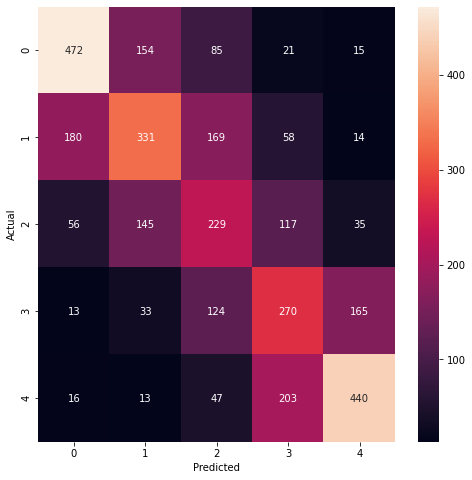

In [115]:
#find accuracy, precision, recall

conf_mat = confusion_matrix(predictions, y_test)
print(classification_report(predictions, y_test))

plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## List Content that model predicted false

In [116]:
labels = df['rate'].unique()

In [164]:
mislabel = []
for index, row in df_pred.iterrows():
    if (int(row['class']) != int(row['predictions'])):
        mislabel.append(row)

df_wrong = pd.DataFrame(mislabel)

In [1]:
df_wrong.head(40)

NameError: name 'df_wrong' is not defined